In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

# Load model with optimization
model = AutoModelForCausalLM.from_pretrained(
    "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    torch_dtype=torch.float16,  # Use FP16 for lower VRAM usage
    device_map="auto"  # Automatically select GPU if available
)

# Move model to GPU (if not done automatically)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model loaded successfully on:", device)


tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model loaded successfully on: cuda


In [2]:
import pandas as pd

# Load the dataset
file_path = "/kaggle/input/dataset-private/indian_electricity_bill_data.csv"  # Update the path if needed
df = pd.read_csv(file_path)

# Check for missing values
print("Missing Values in Each Column:")
print(df.isnull().sum())

# Normalize numerical columns using Min-Max Scaling
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = (df[numeric_cols] - df[numeric_cols].min()) / (df[numeric_cols].max() - df[numeric_cols].min())

# Display first few rows of the normalized dataset
print("\nNormalized Dataset Preview:")
print(df.head())

# Save the cleaned data (optional)
df.to_csv("cleaned_electricity_bill_data.csv", index=False)


Missing Values in Each Column:
Month                    0
Consumption_kWh          0
Fixed_Charges            0
Electricity_Duty_Rate    0
Subsidy                  0
Other_Charges            0
Slab_Bill                0
Total_Bill               0
dtype: int64

Normalized Dataset Preview:
      Month  Consumption_kWh  Fixed_Charges  Electricity_Duty_Rate  Subsidy  \
0  0.636364         0.308017       0.952969               0.873284      0.0   
1  0.181818         0.493670       0.733152               0.257121      0.0   
2  0.818182         0.941640       0.142578               0.194493      0.0   
3  0.000000         0.120004       0.652844               0.936994      0.0   
4  0.000000         0.058289       0.494806               0.967450      1.0   

   Other_Charges  Slab_Bill  Total_Bill  
0       0.795394   0.215690    0.276481  
1       0.888060   0.420028    0.446760  
2       0.495973   0.933152    0.878113  
3       0.070627   0.061863    0.107235  
4       0.633560   0.02861

In [3]:
import pandas as pd

# Load cleaned dataset
file_path = "/kaggle/working/cleaned_electricity_bill_data.csv"
df = pd.read_csv(file_path)

# Function to generate conversation-style training data
def generate_prompt(row):
    return (
        f"User: My electricity consumption this month is {row['Consumption_kWh']:.2f} kWh "
        f"with fixed charges of {row['Fixed_Charges']:.2f} and a duty rate of {row['Electricity_Duty_Rate']:.3f}. "
        f"What will be my bill?\n"
        f"AI: Based on your usage, your estimated bill is {row['Total_Bill']:.2f}.\n"
        f"User: How can I save electricity next month?\n"
        f"AI: You can reduce your bill by optimizing appliance usage, using energy-efficient devices, "
        f"and turning off devices when not needed.\n"
    )

# Apply function to all rows
training_data = df.apply(generate_prompt, axis=1)

# Save to a text file for fine-tuning
training_file_path = "electricity_bill_training_data.txt"
with open(training_file_path, "w", encoding="utf-8") as f:
    f.write("\n".join(training_data))

print("Training data saved as electricity_bill_training_data.txt")


Training data saved as electricity_bill_training_data.txt


In [4]:
!pip install transformers peft bitsandbytes accelerate datasets torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 22.9 MB/s eta 0:00:00:00:0100:01


In [9]:
import torch
import os
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
from transformers import Trainer, DataCollatorForLanguageModeling

# Disable WandB (if you don't want logging)
os.environ["WANDB_DISABLED"] = "true"

# Load tokenizer and model
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")

# Apply LoRA (Low-Rank Adaptation) for efficient fine-tuning
lora_config = LoraConfig(
    r=8, lora_alpha=16, lora_dropout=0.1, bias="none", task_type="CAUSAL_LM"
)
model = get_peft_model(model, lora_config)

# Load dataset and split into train (80%) and eval (20%)
dataset_path = "/kaggle/working/electricity_bill_training_data.txt"  # Ensure this path is correct
dataset = load_dataset("text", data_files={"train": dataset_path})["train"]
dataset = dataset.train_test_split(test_size=0.2)

# Assign train and eval datasets
train_dataset = dataset["train"]
eval_dataset = dataset["test"]

# Tokenize function
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
eval_dataset = eval_dataset.map(tokenize_function, batched=True)

# Data collator for padding
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

# Training arguments
training_args = TrainingArguments(
    output_dir="./fine_tuned_model",
    evaluation_strategy="epoch",  # Fixed this
    save_strategy="epoch",
    logging_dir="./logs",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    num_train_epochs=3,
    save_total_limit=2,
    fp16=True,
    push_to_hub=False
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,  # Evaluation dataset added
    tokenizer=tokenizer,  # Keep tokenizer (not processing_class)
    data_collator=data_collator
)

# Start fine-tuning
trainer.train()

# Save model
trainer.save_model("./fine_tuned_tinyllama")
print("Fine-tuning complete! Model saved to './fine_tuned_tinyllama'.")


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-9-97e32a8892fc>:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1865.176100,0.275761
2,66.429200,0.272846


Fine-tuning complete! Model saved to './fine_tuned_tinyllama'.


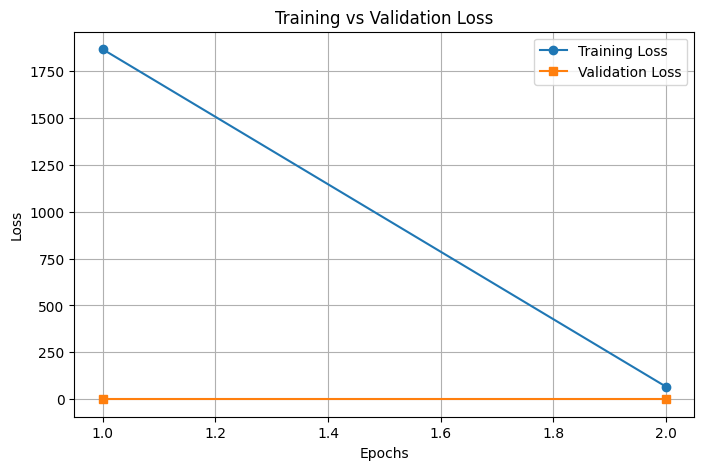

In [10]:
import json
import matplotlib.pyplot as plt

# Load training logs
log_file = "/kaggle/working/fine_tuned_model/checkpoint-1000/trainer_state.json"

with open(log_file, "r") as f:
    logs = json.load(f)

# Extract loss values
epochs = []
train_loss = []
eval_loss = []

for log in logs["log_history"]:
    if "loss" in log:
        epochs.append(log["epoch"])
        train_loss.append(log["loss"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])

# Plot Training & Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label="Training Loss", marker="o")
plt.plot(epochs[:len(eval_loss)], eval_loss, label="Validation Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()


In [17]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load tokenizer and fine-tuned model
model_name = "/kaggle/working/fine_tuned_tinyllama"  # Update with your fine-tuned model path
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")

# Move model to GPU (if available)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 2048)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): lora.Linear(
            (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.1, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=2048, out_features=8, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=8, out_features=2048, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): lora.Linear(
            (base_layer): Linear(in_features=2048, out_features=256, 

In [22]:
def generate_response(prompt, max_length=200):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        output = model.generate(**inputs, max_length=max_length, temperature=0.7, top_p=0.9)
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Example test
test_prompt = "My electricity bill is too high this month. How can I reduce it?"
response = generate_response(test_prompt)
print("Model Response:", response)


Model Response: My electricity bill is too high this month. How can I reduce it?

1. Reduce energy consumption: Turn off lights when not needed, use energy-efficient appliances, and adjust thermostat settings.

2. Use energy-efficient devices: Switch to LED light bulbs, use energy-efficient appliances, and use a programmable thermostat.

3. Optimize usage: Use appliances and devices when they are needed, and turn off devices when not needed.

4. Report usage: Report your usage to your utility company to receive a bill adjustment.

5. Complain: If you are not satisfied with your bill, you can complain to your utility company or the electricity regulator.

6. Use rebates: You can use rebates to reduce your electricity bill. Check with your utility company for available rebates.

7. Switch to a
